In [1]:
import time
import ast
import pandas as pd
import numpy as np
import osmnx as ox
import folium
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from functions import (
    get_centroid, 
    contar_lugares_cercanos, 
    analizar_entorno, 
    haversine, 
    get_high_correlations, 
    plot_cluster_radar, 
    plot_pca_combined_biplot,
    expandir_presencia_carros
)

In [2]:
Info_parking = pd.read_csv("D:/prueba_tecnica_parking/parametrics.csv",sep=";")

In [3]:
Info_parking.describe()

,Client Lot ID,Stall vendor,Spaces,latitud,longitud
count,47.000000,32.000000,47.000000,41.000000,41.000000
mean,30034.489362,40412.406250,89.510638,25.774307,-80.205199
std,21.382513,2897.782655,89.006564,0.024006,0.017591
min,30001.000000,30087.000000,0.000000,25.727044,-80.245088
25%,30019.000000,40127.250000,36.000000,25.767254,-80.219062
50%,30030.000000,40660.000000,69.000000,25.772928,-80.199304
75%,30045.500000,41353.000000,115.000000,25.783309,-80.193800
max,30087.000000,45551.000000,490.000000,25.836615,-80.173153


In [4]:
# Cuenta los valores nulos por columna
nulos_por_columna = Info_parking.isnull().sum()

print("Valores nulos por columna:")
print(nulos_por_columna)

# Si quieres ver el total general de nulos en todo el dataframe
total_nulos = Info_parking.isnull().sum().sum()
print(f"\nTotal de nulos en el dataset: {total_nulos}")

Valores nulos por columna:
nombre            0
direccion         0
Client Lot ID     0
Stall vendor     15
Spaces            0
polygon           4
latitud           6
longitud          6
dtype: int64

Total de nulos en el dataset: 31


#### Imputacion coordenadas nulas : 

In [5]:
mask = Info_parking['latitud'].isna() | Info_parking['longitud'].isna()

centroids = Info_parking.loc[mask, 'polygon'].apply(get_centroid)

Info_parking.loc[mask, 'longitud'] = centroids.apply(lambda x: x[0])
Info_parking.loc[mask, 'latitud'] = centroids.apply(lambda x: x[1])



In [6]:
Info_parking.head(10)

,nombre,direccion,Client Lot ID,Stall vendor,Spaces,polygon,latitud,longitud
0,Lot 1,"US1, SW 27 Ave., Miami, Fl 33133",30001,40902.0,21,"[[[-80.23743, 25.739978], [-80.237435, 25.7398...",25.740239,-80.237534
1,Lot 5,"1075 Biscayne Blvd, Miami, Fl 33132 (Maurice ...",30005,31027.0,40,"[[[-80.188351, 25.78317], [-80.187857, 25.7831...",25.807517,-80.195281
2,Lot 6,3500 Main Highway C.Grove 33133 (Playhouse Lot),30006,42106.0,164,"[[[-80.245089, 25.727044], [-80.245079, 25.726...",25.727044,-80.245088
3,Lot 11,"NW 3 Ave. & NW 3 Ct. bet. NW 1-2 St., Miami, F...",30011,NaN,121,"[[[-80.199525, 25.775813], [-80.199906, 25.775...",25.774923,-80.199304
4,Lot 12,"NW 3 Ave. & NW 3 Ct. bet. NW 2-3 St., Miami, F...",30012,42212.0,97,"[[[-80.199981, 25.775905], [-80.199509, 25.775...",25.775904,-80.199980
5,Lot 13,"NW 3 Ave. & NW 3 Ct., bet. W 3-4 St., Miami, F...",30013,40113.0,94,"[[[-80.20004, 25.777291], [-80.200018, 25.7769...",25.777788,-80.200039
6,Lot 14,"NW 3 Ave. bet. Flagler St. & SW 1 St., Miami, ...",30014,40708.0,188,"[[[-80.199306, 25.773197], [-80.198679, 25.773...",25.773891,-80.199645
7,Lot 15,"Under I-95, SW 2 Ave. & River Dr. bet. SW 1-2 ...",30015,41756.0,254,"[[[-80.199026, 25.773064], [-80.198935, 25.772...",25.773097,-80.197754
8,Lot 16,"Under I-95, SW River Drive, bet. SW 2-3 St., M...",30016,NaN,107,"[[[-80.198704, 25.771929], [-80.198704, 25.771...",25.772242,-80.198666
9,Lot 17,"Under I-95, SW River Drive, SW 3 St., Miami,Fl...",30017,40117.0,130,"[[[-80.199379, 25.772066], [-80.199515, 25.772...",25.771467,-80.198922


#### Validar si hay informacion duplicada:


In [7]:

# Cuenta cuántas filas tienen una dirección que ya apareció antes
total_duplicados = Info_parking['direccion'].duplicated().sum()

print(f"Número de direcciones repetidas: {total_duplicados}")

Número de direcciones repetidas: 0


In [8]:

# Cuenta cuántas filas tienen una dirección que ya apareció antes
total_duplicados = Info_parking['Client Lot ID'].duplicated().sum()

print(f"Número de direcciones repetidas: {total_duplicados}")

Número de direcciones repetidas: 5


In [9]:
Info_parking['Client Lot ID'].value_counts().head(6)

Client Lot ID
30019    6
30001    1
30005    1
30006    1
30011    1
30012    1
Name: count, dtype: int64

### Mapa ubicacion parqueaderos:

In [10]:


df_mapa = Info_parking.dropna(subset=['latitud', 'longitud'])

# 2. Crear el objeto mapa centrado en el promedio de tus coordenadas (Miami)
lat_centro = df_mapa['latitud'].mean()
lon_centro = df_mapa['longitud'].mean()
mapa = folium.Map(location=[lat_centro, lon_centro], zoom_start=13)

# 3. Agregar los marcadores al mapa
for index, fila in df_mapa.iterrows():
    # Creamos un texto para el popup (lo que sale al hacer clic)
    info_popup = f"<b>{fila['nombre']}</b><br>{fila['direccion']}<br>Espacios: {fila['Spaces']}"
    
    folium.Marker(
        location=[fila['latitud'], fila['longitud']],
        popup=folium.Popup(info_popup, max_width=300),
        tooltip=fila['nombre'], # Lo que sale al pasar el mouse
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(mapa)

# 4. Guardar el mapa en un archivo HTML o mostrarlo en un notebook
mapa.save("mapa_parkings_miami.html")
print("Mapa generado con éxito. Abre el archivo 'mapa_parkings_miami.html' en tu navegador.")

Mapa generado con éxito. Abre el archivo 'mapa_parkings_miami.html' en tu navegador.


#### Calcular la distancia en metros entre parqueadero para transacciones y formar el cluster.

#### Calcular la tasa ocupacion hora a hora, que es la demanda del parqueadero hora a hora / Campo Spaces.

#### Calcular centros comerciales a 1 km a la redonda, 
#### Calcular Estadios a 1 km a la redonda
#### Calcular parques a 1 km a la redonda


In [11]:


# 1. Configuración de etiquetas (Tags) para buscar en OpenStreetMap
# Agrupamos todo lo que queremos en un solo diccionario
tags_interes = {
    'natural': 'beach',
    'shop': 'mall',
    'leisure': ['stadium', 'park'],
    'amenity': ['stadium', 'university']
}

df_resultado = Info_parking.copy()

geo_data = df_resultado.apply(lambda row: analizar_entorno(row['latitud'], row['longitud']), axis=1)

df_final = pd.concat([df_resultado, geo_data], axis=1)



In [3]:
df_final["JOIN_ID"] = df_final["Client Lot ID"].astype(str)+"_"+ df_final["Stall vendor"].astype(str)

In [12]:
#df_final.to_csv("parking_info_params.csv",sep="|",index=False)

In [2]:
#df_final = pd.read_csv("parking_info_params.csv",sep="|")

#### Calcular distancias entre parqueaderos:

In [4]:

ids_referencia = [30019,
30001,    
30005 ,   
30006,    
30011  ,  
30012  ,  
30013  ,  
30014  , 
30015  ,  
30016  ,  
30017  ,  
30018 ,   
30020 ,   
30022 ,   
30023  ,  
30026 ,   
30028 ,   
30029 ,   
30030 ,   
30032 ,   
30033 ,   
30036 ,   
30037   , 
30038 ,   
30039 ,   
30040,    
30042 ,   
30043 ,   
30044  ,  
30045  ,  
30046  ,  
30052  ,  
30053 ,   
30054  ,  
30055 ,   
30062 ,   
30068 ,   
30070 ,   
30071 ,   
30072 ,   
30082   , 
30087    ]

# 2. Iterar para crear las nuevas columnas de distancia
for target_id in ids_referencia:
    # Buscar las coordenadas del lote de referencia (latitud y longitud)
    fila_ref = df_final[df_final['Client Lot ID'] == target_id].iloc[0]
    lat_ref = fila_ref['latitud']
    lon_ref = fila_ref['longitud']
    
    # Crear el nombre de la columna, ej: Dist_30001
    nombre_col = f'Dist_{target_id}'
    
    # Aplicar el cálculo de distancia para cada fila del DataFrame
    df_final[nombre_col] = df_final.apply(
        lambda row: haversine(row['latitud'], row['longitud'], lat_ref, lon_ref), axis=1
    ).round(2) # Redondear a 2 decimales para limpieza



In [5]:
df_final.columns

Index(['nombre', 'direccion', 'Client Lot ID', 'Stall vendor', 'Spaces',
       'polygon', 'latitud', 'longitud', 'lugares_cerca_count', 'Playa_1km',
       'Malls_1km', 'stadium_1km', 'park_1km', 'University_1km', 'JOIN_ID',
       'Dist_30019', 'Dist_30001', 'Dist_30005', 'Dist_30006', 'Dist_30011',
       'Dist_30012', 'Dist_30013', 'Dist_30014', 'Dist_30015', 'Dist_30016',
       'Dist_30017', 'Dist_30018', 'Dist_30020', 'Dist_30022', 'Dist_30023',
       'Dist_30026', 'Dist_30028', 'Dist_30029', 'Dist_30030', 'Dist_30032',
       'Dist_30033', 'Dist_30036', 'Dist_30037', 'Dist_30038', 'Dist_30039',
       'Dist_30040', 'Dist_30042', 'Dist_30043', 'Dist_30044', 'Dist_30045',
       'Dist_30046', 'Dist_30052', 'Dist_30053', 'Dist_30054', 'Dist_30055',
       'Dist_30062', 'Dist_30068', 'Dist_30070', 'Dist_30071', 'Dist_30072',
       'Dist_30082', 'Dist_30087'],
      dtype='str')

### Descriptivo parqueadero:

In [6]:
df_final.loc[:,["Spaces"	,"lugares_cerca_count",	"Playa_1km","Malls_1km","stadium_1km","park_1km","University_1km", 'Dist_30019',
       'Dist_30001', 'Dist_30005', 'Dist_30006', 'Dist_30011', 'Dist_30012',
       'Dist_30013', 'Dist_30014', 'Dist_30015', 'Dist_30016', 'Dist_30017',
       'Dist_30018', 'Dist_30020', 'Dist_30022', 'Dist_30023', 'Dist_30026',
       'Dist_30028', 'Dist_30029', 'Dist_30030', 'Dist_30032', 'Dist_30033',
       'Dist_30036', 'Dist_30037', 'Dist_30038', 'Dist_30039', 'Dist_30040',
       'Dist_30042', 'Dist_30043', 'Dist_30044', 'Dist_30045', 'Dist_30046',
       'Dist_30052', 'Dist_30053', 'Dist_30054', 'Dist_30055', 'Dist_30062',
       'Dist_30068', 'Dist_30070', 'Dist_30071', 'Dist_30072', 'Dist_30082',
       'Dist_30087']].describe()

,Spaces,lugares_cerca_count,Playa_1km,Malls_1km,stadium_1km,park_1km,University_1km,Dist_30019,Dist_30001,Dist_30005,...,Dist_30053,Dist_30054,Dist_30055,Dist_30062,Dist_30068,Dist_30070,Dist_30071,Dist_30072,Dist_30082,Dist_30087
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,89.510638,11.106383,0.234043,1.787234,0.446809,8.489362,0.148936,2.621277,5.413404,4.307021,...,4.668085,4.671277,4.677021,6.115745,3.611277,3.876596,6.390638,5.758511,3.116596,3.102340
std,89.006564,5.159348,0.698220,1.573368,0.502538,3.764089,0.359875,2.207388,2.400013,2.288514,...,2.483831,2.486940,2.487773,2.704292,2.193899,2.206499,2.763675,2.599191,1.736607,1.736202
min,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,7.000000,0.000000,0.000000,0.000000,5.500000,0.000000,0.930000,3.680000,3.400000,...,3.890000,3.890000,3.900000,4.800000,2.220000,2.560000,5.040000,4.380000,2.210000,2.180000
50%,69.000000,11.000000,0.000000,1.000000,0.000000,8.000000,0.000000,1.570000,5.440000,3.840000,...,4.310000,4.310000,4.320000,6.310000,3.050000,3.330000,6.630000,5.900000,2.640000,2.610000
75%,115.000000,16.500000,0.000000,3.000000,1.000000,12.000000,0.000000,3.780000,6.340000,4.945000,...,5.490000,5.500000,5.515000,7.035000,4.785000,5.120000,7.365000,6.635000,4.140000,4.140000
max,490.000000,20.000000,4.000000,4.000000,1.000000,15.000000,1.000000,7.780000,11.960000,10.240000,...,10.790000,10.800000,10.810000,13.010000,9.340000,9.680000,13.290000,12.590000,8.670000,8.660000


#### Transactions:

In [7]:

trx = pd.read_csv("transacciones.csv",sep=";")
trx["JOIN_ID"] = trx["Client Lot ID"].astype(str)+"_"+ trx["Stall vendor"].astype(str)

In [8]:
trx.head()

,Fecha de entrada,Total pagado,Client Lot ID,Stall vendor,si es extension o no,duracion en minutos,rate aplicado,JOIN_ID
0,10/01/2025 0:00,10.35,30019,40123.0,IS_EXTENSION,120,Rate - 35 - Event rate may apply,30019_40123.0
1,10/01/2025 0:01,3.50,30091,45552.0,IS_NOT_EXTENSION,60,"45552 $3.00 per hour, 8 hr. max",30091_45552.0
2,10/01/2025 0:33,1.50,30082,45350.0,IS_EXTENSION,30,NaN,30082_45350.0
3,10/01/2025 0:43,3.15,30014,40708.0,IS_EXTENSION,60,"Rate - 25 - $2.50/h - 5h max 7am - 4am, enfor...",30014_40708.0
4,10/01/2025 0:52,1.50,30082,45350.0,IS_EXTENSION,30,"Rate - 33 - $2.00/h - 8h max 6pm-2am, enforce...",30082_45350.0


In [9]:
trx.dtypes


Fecha de entrada            str
Total pagado            float64
Client Lot ID             int64
Stall vendor            float64
si es extension o no        str
duracion en minutos       int64
rate aplicado               str
JOIN_ID                     str
dtype: object

In [10]:

# 1. Convertir la columna a datetime
# Usamos dayfirst=False porque tus datos (10/31/2025) indican formato Mes/Día/Año
trx['Fecha de entrada'] = pd.to_datetime(
    trx['Fecha de entrada'], 
    format='mixed', 
    dayfirst=False
)


In [11]:
trx.shape

(69895, 8)

In [12]:

# Cuenta cuántas filas tienen una dirección que ya apareció antes
total_duplicados = df_final['Client Lot ID'].duplicated().sum()

print(f"Número de direcciones repetidas: {total_duplicados}")

Número de direcciones repetidas: 5


In [13]:
# Cuenta los valores nulos por columna
nulos_por_columna = trx.isnull().sum()

print("Valores nulos por columna:")
print(nulos_por_columna)

# Si quieres ver el total general de nulos en todo el dataframe
total_nulos = trx.isnull().sum().sum()
print(f"\nTotal de nulos en el dataset: {total_nulos}")

Valores nulos por columna:
Fecha de entrada           0
Total pagado               0
Client Lot ID              0
Stall vendor              25
si es extension o no       0
duracion en minutos        0
rate aplicado           8588
JOIN_ID                   25
dtype: int64

Total de nulos en el dataset: 8638


In [14]:
# Cuenta cuántas filas son exactamente iguales a una anterior
total_duplicados = trx.duplicated().sum()

print(f"Total de filas completamente repetidas: {total_duplicados}")

Total de filas completamente repetidas: 591


In [15]:
### Filas repetidas:

filas_identicas = trx[trx.duplicated(keep=False)]

# Ordenar por una columna conocida para ver los pares juntos
filas_identicas.sort_values(by='Client Lot ID')

,Fecha de entrada,Total pagado,Client Lot ID,Stall vendor,si es extension o no,duracion en minutos,rate aplicado,JOIN_ID
11114,2025-10-05 17:31:00,5.50,30005,31027.0,IS_NOT_EXTENSION,60,"$5/hr first 2 hrs, $3 additional hrs $25 Max, ...",30005_31027.0
11324,2025-10-05 18:28:00,5.50,30005,31027.0,IS_NOT_EXTENSION,60,"$5/hr first 2 hrs, $3 additional hrs $25 Max, ...",30005_31027.0
11325,2025-10-05 18:28:00,5.50,30005,31027.0,IS_NOT_EXTENSION,60,"$5/hr first 2 hrs, $3 additional hrs $25 Max, ...",30005_31027.0
26569,2025-10-12 13:42:00,5.50,30005,31027.0,IS_NOT_EXTENSION,60,"$5/hr first 2 hrs, $3 additional hrs $25 Max, ...",30005_31027.0
26572,2025-10-12 13:42:00,5.50,30005,31027.0,IS_NOT_EXTENSION,60,"$5/hr first 2 hrs, $3 additional hrs $25 Max, ...",30005_31027.0
...,...,...,...,...,...,...,...,...
6295,2025-10-04 08:23:00,8.50,30311,45433.0,IS_NOT_EXTENSION,120,NaN,30311_45433.0
6296,2025-10-04 08:23:00,8.50,30311,45433.0,IS_NOT_EXTENSION,120,NaN,30311_45433.0
6279,2025-10-04 08:17:00,8.65,30311,45433.0,IS_NOT_EXTENSION,120,NaN,30311_45433.0
6280,2025-10-04 08:18:00,8.50,30311,45433.0,IS_NOT_EXTENSION,120,NaN,30311_45433.0


In [16]:
### Retiramos filas repetidas:

trx_clean = trx.drop_duplicates()

### Imputacion rate aplicado, valores nulos:
<br>

##### El proceso de imputacion consiste en agregar a nivel hora y nivel fecha y Client Lot ID, y tomar el valor existente de la 
##### columna 'rate aplicado' colocando el valor existente en esa frana horaria del mismo Client Lot ID. 

In [17]:
# 1. Asegurar formato datetime (si no lo has hecho ya)
trx_clean['Fecha de entrada'] = pd.to_datetime(trx_clean['Fecha de entrada'], format='mixed')

# 2. Crear columnas temporales para agrupar
trx_clean['temp_hora'] = trx_clean['Fecha de entrada'].dt.hour

trx_clean['rate aplicado'] = trx_clean.groupby(['JOIN_ID', 'temp_hora'])['rate aplicado'].transform(
    lambda x: x.ffill().bfill()
)

# 4. Limpiar columnas temporales y verificar
trx_clean.drop(columns=[ 'temp_hora'], inplace=True)

nulos_finales = trx_clean['rate aplicado'].isna().sum()

In [18]:
# Cuenta los valores nulos por columna
nulos_por_columna = trx.isnull().sum()

print("Valores nulos por columna:")
print(nulos_por_columna)

# Si quieres ver el total general de nulos en todo el dataframe
total_nulos = trx.isnull().sum().sum()

Valores nulos por columna:
Fecha de entrada           0
Total pagado               0
Client Lot ID              0
Stall vendor              25
si es extension o no       0
duracion en minutos        0
rate aplicado           8588
JOIN_ID                   25
dtype: int64


In [19]:
# Cuenta los valores nulos por columna
nulos_por_columna = trx_clean.isnull().sum()

print("Valores nulos por columna:")
print(nulos_por_columna)

# Si quieres ver el total general de nulos en todo el dataframe
total_nulos = trx_clean.isnull().sum().sum()
print(f"\nTotal de nulos en el dataset: {total_nulos}")

Valores nulos por columna:
Fecha de entrada         0
Total pagado             0
Client Lot ID            0
Stall vendor            25
si es extension o no     0
duracion en minutos      0
rate aplicado           42
JOIN_ID                 25
dtype: int64

Total de nulos en el dataset: 92


#### Estimacion, ocupacion Carros por hora para cada parqueadero.

In [20]:

trx_clean['start'] = pd.to_datetime(trx_clean['Fecha de entrada'])
trx_clean['end'] = trx_clean['start'] + pd.to_timedelta(trx_clean['duracion en minutos'], unit='m')


filas_conteo = []
for _, row in trx_clean.iterrows():
    filas_conteo.extend(expandir_presencia_carros(row))

df_presencia = pd.DataFrame(filas_conteo)

# 5. Agrupar para obtener el conteo final de carros por hora
# Esto nos dirá cuántos carros "vivos" había en ese JOIN_ID en ese momento
df_conteo_final = df_presencia.groupby(['Fecha', 'Hora', 'JOIN_ID']).size().reset_index(name='Cantidad_Carros')


df_conteo_final = df_conteo_final.sort_values(by=['Fecha', 'Hora'])

df_conteo_final_rate = df_conteo_final.groupby('JOIN_ID')['Cantidad_Carros'].mean().reset_index()

df_conteo_final_rate["Cantidad_Carros"] = np.ceil(df_conteo_final_rate["Cantidad_Carros"])

 

In [21]:
# Forma más común en Python
resultado = trx_clean[trx_clean["rate aplicado"].isnull()]


In [22]:
trx_clean = trx_clean.dropna(subset=['rate aplicado'])


#### Descripcion Transacciones:

In [23]:
trx_clean.dtypes

Fecha de entrada        datetime64[us]
Total pagado                   float64
Client Lot ID                    int64
Stall vendor                   float64
si es extension o no               str
duracion en minutos              int64
rate aplicado                      str
JOIN_ID                            str
start                   datetime64[us]
end                     datetime64[us]
dtype: object

In [24]:
trx_clean.describe()

,Fecha de entrada,Total pagado,Client Lot ID,Stall vendor,duracion en minutos,start,end
count,69262,69262.000000,69262.000000,69262.000000,69262.000000,69262,69262
mean,2025-10-16 15:14:41.470257,9.275616,30043.799500,40214.526840,207.120152,2025-10-16 15:14:41.470257,2025-10-16 18:41:48.679405
min,2025-10-01 00:00:00,0.000000,30001.000000,30087.000000,0.000000,2025-10-01 00:00:00,2025-10-01 01:01:00
25%,2025-10-09 08:52:00,3.650000,30019.000000,40123.000000,60.000000,2025-10-09 08:52:00,2025-10-09 11:07:00
50%,2025-10-16 18:58:01.500000,8.000000,30023.000000,40612.000000,120.000000,2025-10-16 18:58:01.500000,2025-10-16 22:05:39.500000
75%,2025-10-24 12:09:37.500000,12.350000,30062.000000,41744.000000,180.000000,2025-10-24 12:09:37.500000,2025-10-24 14:54:41.500000
max,2025-10-31 23:59:28,84.650000,32007.000000,49215.000000,2940.000000,2025-10-31 23:59:28,2025-11-02 15:02:42
std,NaN,7.284541,42.352159,3608.248614,238.378365,NaN,NaN


In [25]:
trx_clean["Client Lot ID"].unique()

array([30019, 30091, 30082, 30014, 30023, 30042, 30055, 30068, 30070,
       30006, 30033, 30306, 30038, 30017, 30030, 30062, 30311, 30036,
       30094, 30044, 30015, 30005, 30012, 30028, 30001, 30040, 30071,
       30013, 30305, 30087, 30089, 30043, 30032, 30059, 30004, 30092,
       30207, 30007, 32007, 30003, 31024])

In [26]:
conteo_lotes = trx_clean['Client Lot ID'].value_counts()

print("Transacciones por Client Lot ID:")
print(conteo_lotes)

Transacciones por Client Lot ID:
Client Lot ID
30019    19247
30091     7869
30055     7814
30006     7346
30062     5329
30068     2936
30017     2718
30082     2310
30038     2058
30005     1901
30094     1330
30014     1290
30012      997
30023      924
30042      636
30070      633
30071      476
30033      473
30044      448
30030      435
30311      404
30040      367
30306      227
30015      200
30305      155
30036      145
30001      135
30087      131
30013      119
30028       81
30089       61
30092       27
30032       13
30004       10
30207        4
30007        4
30059        3
30043        2
32007        2
30003        1
31024        1
Name: count, dtype: int64


#### Agregacion y calculo de caracteristicas:

In [27]:

# 1. Preparación de columnas temporales para el análisis
df = trx_clean.copy()
df['fecha'] = df['Fecha de entrada'].dt.date
df['semana'] = df['Fecha de entrada'].dt.isocalendar().week
df['mes_año'] = df['Fecha de entrada'].dt.to_period('M')

# --- BLOQUE 1: Totales Generales por Lote ---
resumen = df.groupby('JOIN_ID').agg(
    Total_dinero=('Total pagado', 'sum'),
    No_transacciones=('Total pagado', 'count'),
    Promedio_general_ticket=('Total pagado', 'mean')
)

# --- BLOQUE 2: Extensiones (Totales) ---
extensiones = df.pivot_table(
    index='JOIN_ID', 
    columns='si es extension o no', 
    values='Total pagado', 
    aggfunc='count', 
    fill_value=0
)
resumen = resumen.join(extensiones)

# --- BLOQUE 3: Promedios Temporales (Transacciones y Extensiones) ---
# Calculamos primero totales por día e ID para luego promediar
daily_counts = df.groupby(['JOIN_ID', 'fecha', 'si es extension o no']).size().unstack(fill_value=0)
weekly_counts = df.groupby(['JOIN_ID', 'semana', 'si es extension o no']).size().unstack(fill_value=0)

resumen['avg_daily_IS_EXTENSION'] = daily_counts['IS_EXTENSION'].groupby('JOIN_ID').mean()
resumen['avg_weekly_IS_EXTENSION'] = weekly_counts['IS_EXTENSION'].groupby('JOIN_ID').mean()
resumen['avg_daily_IS_NOT_EXTENSION'] = daily_counts['IS_NOT_EXTENSION'].groupby('JOIN_ID').mean()
resumen['avg_weekly_IS_NOT_EXTENSION'] = weekly_counts['IS_NOT_EXTENSION'].groupby('JOIN_ID').mean()

# Promedio de transacciones totales (diario y semanal)
resumen['avg_transacciones_diario'] = df.groupby(['JOIN_ID', 'fecha']).size().groupby('JOIN_ID').mean()
resumen['avg_transacciones_semanal'] = df.groupby(['JOIN_ID', 'semana']).size().groupby('JOIN_ID').mean()

# --- BLOQUE 4: Promedios de Dinero (Recaudación y Ticket Promedio) ---

resumen['recaudacion_avg_diaria'] = df.groupby(['JOIN_ID', 'fecha'])['Total pagado'].sum().groupby('JOIN_ID').mean()
resumen['recaudacion_avg_semanal'] = df.groupby(['JOIN_ID', 'semana'])['Total pagado'].sum().groupby('JOIN_ID').mean()


daily_ticket = df.groupby(['JOIN_ID', 'fecha'])['Total pagado'].mean().reset_index()
resumen['ticket_promedio_diario_avg'] = daily_ticket.groupby('JOIN_ID')['Total pagado'].mean()

# Ahora por mes
monthly_ticket = df.groupby(['JOIN_ID', 'mes_año'])['Total pagado'].mean().reset_index()
resumen['ticket_promedio_mensual_avg'] = monthly_ticket.groupby('JOIN_ID')['Total pagado'].mean()

resumen = pd.merge(resumen, df_conteo_final_rate, on='JOIN_ID', how='inner')
 
# --- LIMPIEZA FINAL ---
resumen = resumen.fillna(0).reset_index()
del resumen["index"]

### DATA_FRAME FINAL:

In [28]:
df_resultado_F = pd.merge(df_final, resumen, on='JOIN_ID', how='inner')
df_resultado_F["ID_F"] = df_resultado_F["nombre"]+"_"+df_resultado_F["Client Lot ID"].astype(str)

In [29]:
df_resultado_F.columns

Index(['nombre', 'direccion', 'Client Lot ID', 'Stall vendor', 'Spaces',
       'polygon', 'latitud', 'longitud', 'lugares_cerca_count', 'Playa_1km',
       'Malls_1km', 'stadium_1km', 'park_1km', 'University_1km', 'JOIN_ID',
       'Dist_30019', 'Dist_30001', 'Dist_30005', 'Dist_30006', 'Dist_30011',
       'Dist_30012', 'Dist_30013', 'Dist_30014', 'Dist_30015', 'Dist_30016',
       'Dist_30017', 'Dist_30018', 'Dist_30020', 'Dist_30022', 'Dist_30023',
       'Dist_30026', 'Dist_30028', 'Dist_30029', 'Dist_30030', 'Dist_30032',
       'Dist_30033', 'Dist_30036', 'Dist_30037', 'Dist_30038', 'Dist_30039',
       'Dist_30040', 'Dist_30042', 'Dist_30043', 'Dist_30044', 'Dist_30045',
       'Dist_30046', 'Dist_30052', 'Dist_30053', 'Dist_30054', 'Dist_30055',
       'Dist_30062', 'Dist_30068', 'Dist_30070', 'Dist_30071', 'Dist_30072',
       'Dist_30082', 'Dist_30087', 'Total_dinero', 'No_transacciones',
       'Promedio_general_ticket', 'IS_EXTENSION', 'IS_NOT_EXTENSION',
       'avg_daily

In [53]:
df_final.columns

Index(['nombre', 'direccion', 'Client Lot ID', 'Stall vendor', 'Spaces',
       'polygon', 'latitud', 'longitud', 'lugares_cerca_count', 'Playa_1km',
       'Malls_1km', 'stadium_1km', 'park_1km', 'University_1km', 'JOIN_ID',
       'Dist_30019', 'Dist_30001', 'Dist_30005', 'Dist_30006', 'Dist_30011',
       'Dist_30012', 'Dist_30013', 'Dist_30014', 'Dist_30015', 'Dist_30016',
       'Dist_30017', 'Dist_30018', 'Dist_30020', 'Dist_30022', 'Dist_30023',
       'Dist_30026', 'Dist_30028', 'Dist_30029', 'Dist_30030', 'Dist_30032',
       'Dist_30033', 'Dist_30036', 'Dist_30037', 'Dist_30038', 'Dist_30039',
       'Dist_30040', 'Dist_30042', 'Dist_30043', 'Dist_30044', 'Dist_30045',
       'Dist_30046', 'Dist_30052', 'Dist_30053', 'Dist_30054', 'Dist_30055',
       'Dist_30062', 'Dist_30068', 'Dist_30070', 'Dist_30071', 'Dist_30072',
       'Dist_30082', 'Dist_30087'],
      dtype='str')

#### Segmentacion: 

In [32]:
df_resultado_F.columns

Index(['nombre', 'direccion', 'Client Lot ID', 'Stall vendor', 'Spaces',
       'polygon', 'latitud', 'longitud', 'lugares_cerca_count', 'Playa_1km',
       'Malls_1km', 'stadium_1km', 'park_1km', 'University_1km', 'JOIN_ID',
       'Dist_30019', 'Dist_30001', 'Dist_30005', 'Dist_30006', 'Dist_30011',
       'Dist_30012', 'Dist_30013', 'Dist_30014', 'Dist_30015', 'Dist_30016',
       'Dist_30017', 'Dist_30018', 'Dist_30020', 'Dist_30022', 'Dist_30023',
       'Dist_30026', 'Dist_30028', 'Dist_30029', 'Dist_30030', 'Dist_30032',
       'Dist_30033', 'Dist_30036', 'Dist_30037', 'Dist_30038', 'Dist_30039',
       'Dist_30040', 'Dist_30042', 'Dist_30043', 'Dist_30044', 'Dist_30045',
       'Dist_30046', 'Dist_30052', 'Dist_30053', 'Dist_30054', 'Dist_30055',
       'Dist_30062', 'Dist_30068', 'Dist_30070', 'Dist_30071', 'Dist_30072',
       'Dist_30082', 'Dist_30087', 'Total_dinero', 'No_transacciones',
       'Promedio_general_ticket', 'IS_EXTENSION', 'IS_NOT_EXTENSION',
       'avg_daily

In [33]:
df_resultado_F_CL = df_resultado_F.loc[:,['ID_F',"Spaces",'lugares_cerca_count', 'Playa_1km',
       'Malls_1km', 'stadium_1km', 'park_1km', 'University_1km', 'Dist_30019',
       'Dist_30001', 'Dist_30005', 'Dist_30006', 'Dist_30011', 'Dist_30012',
       'Dist_30013', 'Dist_30014', 'Dist_30015', 'Dist_30016', 'Dist_30017',
       'Dist_30018', 'Dist_30020', 'Dist_30022', 'Dist_30023', 'Dist_30026',
       'Dist_30028', 'Dist_30029', 'Dist_30030', 'Dist_30032', 'Dist_30033',
       'Dist_30036', 'Dist_30037', 'Dist_30038', 'Dist_30039', 'Dist_30040',
       'Dist_30042', 'Dist_30043', 'Dist_30044', 'Dist_30045', 'Dist_30046',
       'Dist_30052', 'Dist_30053', 'Dist_30054', 'Dist_30055', 'Dist_30062',
       'Dist_30068', 'Dist_30070', 'Dist_30071', 'Dist_30072', 'Dist_30082',
       'Dist_30087', 'Total_dinero', 'No_transacciones',
       'Promedio_general_ticket', 'IS_EXTENSION', 'IS_NOT_EXTENSION',
       'avg_daily_IS_EXTENSION', 'avg_weekly_IS_EXTENSION',
       'avg_daily_IS_NOT_EXTENSION', 'avg_weekly_IS_NOT_EXTENSION',
       'avg_transacciones_diario', 'avg_transacciones_semanal',
       'recaudacion_avg_diaria', 'recaudacion_avg_semanal',
       'ticket_promedio_diario_avg', 'ticket_promedio_mensual_avg','Cantidad_Carros']]

df_resultado_F_CL["rate_ocupacion_avg"] = df_resultado_F_CL["Cantidad_Carros"] /df_resultado_F_CL["Spaces"]

### Calculo de correlaciones, PCA y Cluster de parqueaderos:

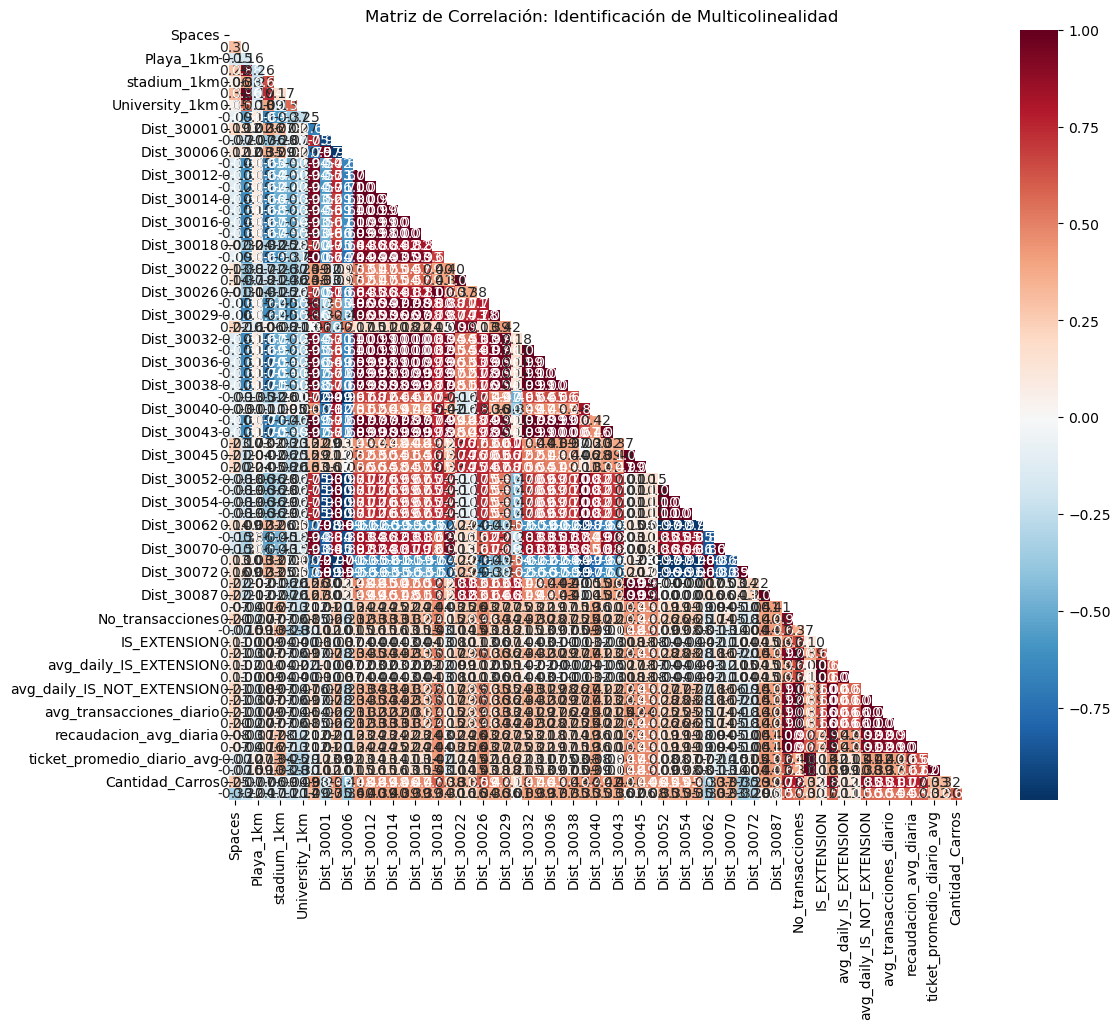

In [34]:


# Seleccionamos solo las variables numéricas
X = df_resultado_F_CL.select_dtypes(include=[np.number]).drop(columns=['ID_F'], errors='ignore')

# Calcular la matriz de correlación
corr_matrix = X.corr()

# Configurar el gráfico
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Máscara para ver solo la mitad inferior
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title("Matriz de Correlación: Identificación de Multicolinealidad")
plt.show()

In [35]:
reporte_colinealidad, sugerencia_drop = get_high_correlations(X, threshold=0.9)
sugerencia_drop.extend(["Dist_30019",	"Dist_30001",	"Dist_30018",	"Dist_30022",	"Dist_30040",	"Dist_30044","IS_EXTENSION"])
sugerencia_drop.remove('No_transacciones')


In [36]:
sugerencia_drop

['park_1km',
 'Dist_30005',
 'Dist_30006',
 'Dist_30011',
 'Dist_30012',
 'Dist_30013',
 'Dist_30014',
 'Dist_30015',
 'Dist_30016',
 'Dist_30017',
 'Dist_30020',
 'Dist_30023',
 'Dist_30026',
 'Dist_30028',
 'Dist_30029',
 'Dist_30030',
 'Dist_30032',
 'Dist_30033',
 'Dist_30036',
 'Dist_30037',
 'Dist_30038',
 'Dist_30039',
 'Dist_30042',
 'Dist_30043',
 'Dist_30045',
 'Dist_30046',
 'Dist_30052',
 'Dist_30053',
 'Dist_30054',
 'Dist_30055',
 'Dist_30062',
 'Dist_30068',
 'Dist_30070',
 'Dist_30071',
 'Dist_30072',
 'Dist_30082',
 'Dist_30087',
 'IS_NOT_EXTENSION',
 'avg_daily_IS_EXTENSION',
 'avg_weekly_IS_EXTENSION',
 'avg_daily_IS_NOT_EXTENSION',
 'avg_weekly_IS_NOT_EXTENSION',
 'avg_transacciones_diario',
 'avg_transacciones_semanal',
 'recaudacion_avg_diaria',
 'recaudacion_avg_semanal',
 'ticket_promedio_diario_avg',
 'ticket_promedio_mensual_avg',
 'Dist_30019',
 'Dist_30001',
 'Dist_30018',
 'Dist_30022',
 'Dist_30040',
 'Dist_30044',
 'IS_EXTENSION']

In [37]:
df_resultado_F_CL_A = df_resultado_F_CL.drop(columns=sugerencia_drop)

In [38]:
df_resultado_F_CL_A["rate_ocupacion_avg"].describe()

count    29.000000
mean      0.226295
std       0.201320
min       0.011811
25%       0.096296
50%       0.153846
75%       0.333333
max       0.800000
Name: rate_ocupacion_avg, dtype: float64

In [39]:
df_resultado_F_CL_A["Total_dinero_log"] = np.log(df_resultado_F_CL_A["Total_dinero"])
df_resultado_F_CL_A["No_transacciones_log"] = np.log(df_resultado_F_CL_A["No_transacciones"])

In [40]:
df_resultado_F_CL_A.columns

Index(['ID_F', 'Spaces', 'lugares_cerca_count', 'Playa_1km', 'Malls_1km',
       'stadium_1km', 'University_1km', 'Total_dinero', 'No_transacciones',
       'Promedio_general_ticket', 'Cantidad_Carros', 'rate_ocupacion_avg',
       'Total_dinero_log', 'No_transacciones_log'],
      dtype='str')

In [41]:
df_resultado_F_CL_A

,ID_F,Spaces,lugares_cerca_count,Playa_1km,Malls_1km,stadium_1km,University_1km,Total_dinero,No_transacciones,Promedio_general_ticket,Cantidad_Carros,rate_ocupacion_avg,Total_dinero_log,No_transacciones_log
0,Lot 1_30001,21,4,0,0,0,0,434.25,122,3.559426,3.0,0.142857,6.073620,4.804021
1,Lot 5_30005,40,8,1,1,0,0,14945.15,1901,7.861731,11.0,0.275000,9.612142,7.550135
2,Lot 6_30006,164,10,0,1,0,0,92039.75,7345,12.530939,128.0,0.780488,11.429976,8.901775
3,Lot 13_30013,94,13,0,1,0,0,580.95,119,4.881933,3.0,0.031915,6.364665,4.779123
4,Lot 14_30014,188,16,0,3,0,0,6967.90,1222,5.702046,6.0,0.031915,8.849069,7.108244
5,Lot 15_30015,254,18,0,4,1,0,1291.70,200,6.458500,3.0,0.011811,7.163714,5.298317
6,Lot 17_30017,130,18,0,3,0,1,10670.05,2718,3.925699,19.0,0.146154,9.275196,7.907652
7,Lot 19-1_30019,85,13,0,4,1,0,49346.15,2956,16.693555,18.0,0.211765,10.806615,7.991592
8,Lot 19-2_30019,60,9,0,2,1,0,42663.40,2739,15.576269,17.0,0.283333,10.661097,7.915348
9,Lot 19-3_30019,69,12,0,3,1,0,72491.50,4910,14.764053,27.0,0.391304,11.191225,8.499029


In [42]:
df_resultado_F_CL_A.columns

Index(['ID_F', 'Spaces', 'lugares_cerca_count', 'Playa_1km', 'Malls_1km',
       'stadium_1km', 'University_1km', 'Total_dinero', 'No_transacciones',
       'Promedio_general_ticket', 'Cantidad_Carros', 'rate_ocupacion_avg',
       'Total_dinero_log', 'No_transacciones_log'],
      dtype='str')

### Calculo K Optimo.

D:\Programas\Anaconda\envs\geo-open\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
D:\Programas\Anaconda\envs\geo-open\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Programas\Anaconda\envs\geo-open\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, wh

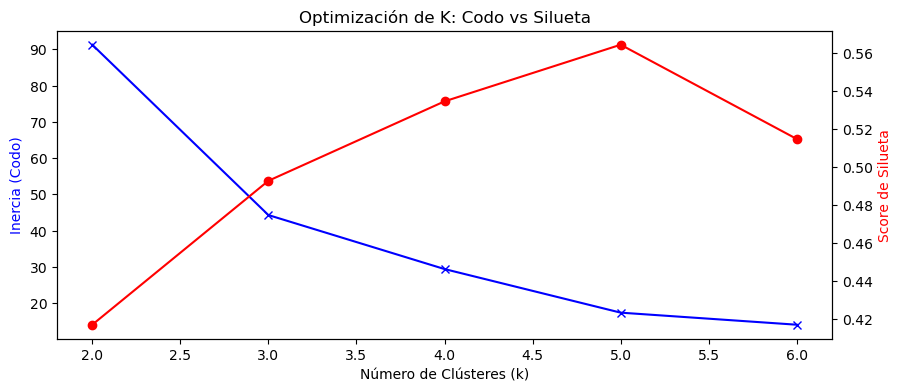

In [43]:
df_clustering = df_resultado_F_CL_A.copy()


features = [
    'Spaces', 'lugares_cerca_count', 'Playa_1km', 'Malls_1km', 
    'stadium_1km', 'University_1km', 'Promedio_general_ticket', 
    'Total_dinero_log', 'No_transacciones_log','rate_ocupacion_avg'
]

X = df_clustering[features]

# 2. Escalado Estándar (Crucial para PCA y K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA: Reducción para visualización y eliminación de ruido
# Reducimos a 2 componentes para poder graficar en 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_clustering['pca_1'] = X_pca[:, 0]
df_clustering['pca_2'] = X_pca[:, 1]

# 4. Encontrar el K Óptimo (Método del Codo y Silueta)
inercias = []
siluetas = []
rango_k = range(2, 7) # Para 32 filas, no conviene más de 6 clústeres

for k in rango_k:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_pca)
    inercias.append(km.inertia_)
    siluetas.append(silhouette_score(X_pca, labels))

# Visualización de métricas de optimización
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(rango_k, inercias, 'bx-')
ax1.set_xlabel('Número de Clústeres (k)')
ax1.set_ylabel('Inercia (Codo)', color='b')
ax2 = ax1.twinx()
ax2.plot(rango_k, siluetas, 'ro-')
ax2.set_ylabel('Score de Silueta', color='r')
plt.title('Optimización de K: Codo vs Silueta')
plt.show()



### K Optimo = 3.

D:\Programas\Anaconda\envs\geo-open\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Programas\Anaconda\envs\geo-open\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


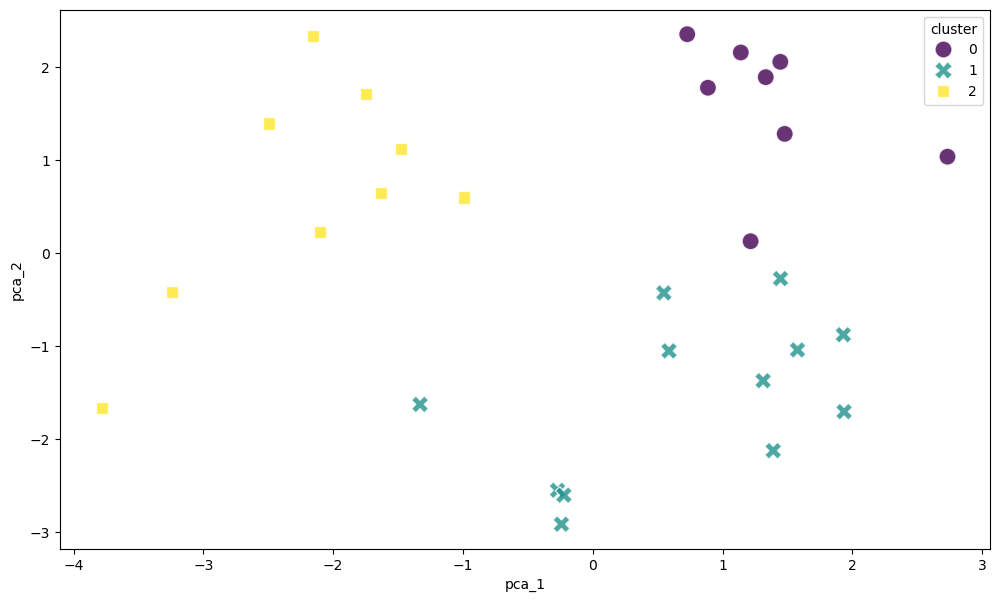

In [44]:

k_optimo = 3 # Cambiar según el gráfico anterior
kmeans_final = KMeans(n_clusters=k_optimo, n_init=10, random_state=42)
df_clustering['cluster'] = kmeans_final.fit_predict(X_pca)

# 6. Visualización de la Segmentación
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x='pca_1', y='pca_2', 
    hue='cluster', 
    style='cluster',
    data=df_clustering, 
    palette='viridis', 
    s=150, alpha=0.8
)
df_clustering['cluster'] = kmeans_final.fit_predict(X_pca)

### Resumen Descriptivo Cluster:

In [45]:
# 1. Definimos las columnas que queremos resumir (todas menos las ignoradas y el clúster)
columnas_interes = [c for c in df_clustering.columns if c not in ['ID_F', 'pca_1', 'pca_2', 'cluster']]

# 2. Creamos la tabla descriptiva con promedios, mínimos y máximos
resumen_clusters = df_clustering.groupby('cluster')[columnas_interes].agg(['mean', 'min', 'max','count'])

# 3. Agregamos el conteo de parqueaderos por clúster
# Lo añadimos como la primera columna para que sea lo primero que leas
resumen_clusters.insert(0, ('General', 'Cantidad_Parqueaderos'), df_clustering.groupby('cluster').size())

# 4. (Opcional) Transponer para que sea más fácil leer con muchas columnas
# resumen_clusters_T = resumen_clusters.T


In [46]:
#resumen_clusters.to_csv("resultados_segmentacion_parkings.csv",sep="|",index=False)

In [47]:
resumen_clusters.T

cluster                                                   0             1  \
General                 Cantidad_Parqueaderos      8.000000     12.000000   
Spaces                  mean                      80.500000     61.666667   
                        min                       40.000000      5.000000   
                        max                      164.000000    189.000000   
                        count                      8.000000     12.000000   
lugares_cerca_count     mean                      11.500000      6.333333   
                        min                        9.000000      2.000000   
                        max                       13.000000     13.000000   
                        count                      8.000000     12.000000   
Playa_1km               mean                       0.000000      0.250000   
                        min                        0.000000      0.000000   
                        max                        0.000000      2.000000   
                        count                      8.000000     12.000000   
Malls_1km               mean                       2.625000      0.333333   
                        min                        1.000000      0.000000   
                        max                        4.000000      1.000000   
                        count                      8.000000     12.000000   
stadium_1km             mean                       0.750000      0.083333   
                        min                        0.000000      0.000000   
                        max                        1.000000      1.000000   
                        count                      8.000000     12.000000   
University_1km          mean                       0.000000      0.000000   
                        min                        0.000000      0.000000   
                        max                        0.000000      0.000000   
                        count                      8.000000     12.000000   
Total_dinero            mean                   53621.501250   6398.070833   
                        min                    38372.600000    434.250000   
                        max                    92039.750000  14945.150000   
                        count                      8.000000     12.000000   
No_transacciones        mean                    3989.875000    899.750000   
                        min                     2409.000000    119.000000   
                        max                     7345.000000   2936.000000   
                        count                      8.000000     12.000000   
Promedio_general_ticket mean                      14.169773      7.749515   
                        min                        7.285359      1.714110   
                        max                       16.693555     19.319036   
                        count                      8.000000     12.000000   
Cantidad_Carros         mean                      33.875000      8.583333   
                        min                       15.000000      2.000000   
                        max                      128.000000     20.000000   
                        count                      8.000000     12.000000   
rate_ocupacion_avg      mean                       0.372531      0.223622   
                        min                        0.211765      0.027523   
                        max                        0.780488      0.800000   
                        count                      8.000000     12.000000   
Total_dinero_log        mean                      10.842929      8.062947   
                        min                       10.555099      6.073620   
                        max                       11.429976      9.612142   
                        count                      8.000000     12.000000   
No_transacciones_log    mean                       8.219244      6.271367   
                        min                        7.786967      4.779123

In [48]:
df_clustering.columns

Index(['ID_F', 'Spaces', 'lugares_cerca_count', 'Playa_1km', 'Malls_1km',
       'stadium_1km', 'University_1km', 'Total_dinero', 'No_transacciones',
       'Promedio_general_ticket', 'Cantidad_Carros', 'rate_ocupacion_avg',
       'Total_dinero_log', 'No_transacciones_log', 'pca_1', 'pca_2',
       'cluster'],
      dtype='str')

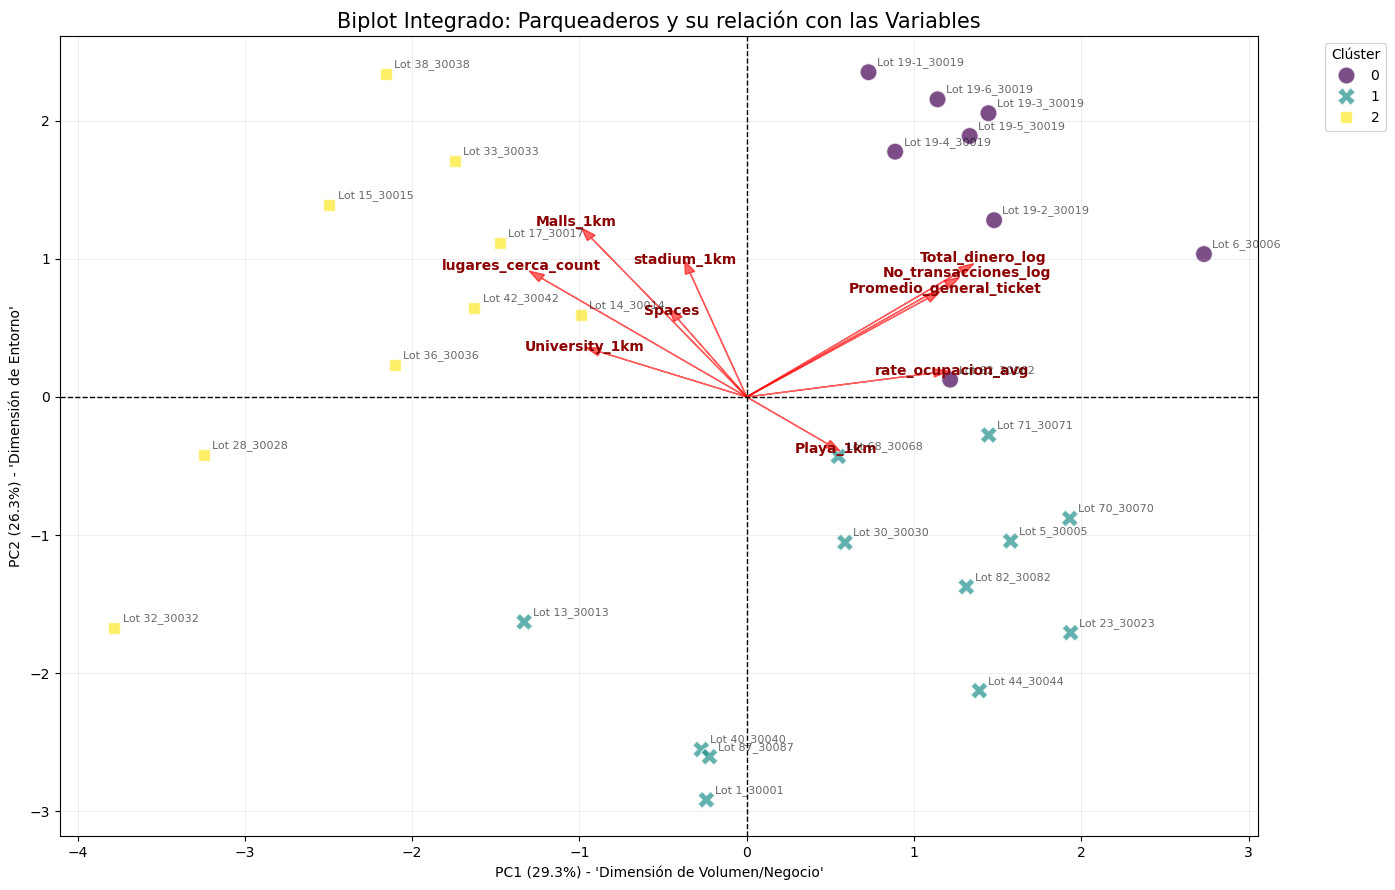

In [49]:
features_modelo = [
    'Spaces','lugares_cerca_count', 'Playa_1km', 'Malls_1km', 
    'stadium_1km', 'University_1km', 'Promedio_general_ticket', 
    'Total_dinero_log', 'No_transacciones_log',"rate_ocupacion_avg"
]

# 2. Preparación de datos (Asegurando que las transformaciones log existan)
# Suponiendo que df_resultado_F es tu DataFrame principal
X = df_clustering[features_modelo].copy()

# 3. Escalado Estándar (Obligatorio para PCA)
# Esto asegura que cada variable contribuya equitativamente al modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Cálculo del objeto pca_modelo
# Calculamos las componentes para reducir la dimensionalidad
pca_modelo = PCA(n_components=2)
pca_modelo.fit(X_scaled)
plot_pca_combined_biplot(df_clustering, pca_modelo, features_modelo)